# Hawaii Climate Analysis

In [1]:
#Importing dependencies for plotting
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import datetime as dt

In [2]:
# Importing Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, distinct

In [3]:
# Database Setup
engine = create_engine("sqlite:////Users/daryarudych/Desktop/repos/SQL-Python/hawaii.sqlite")

In [4]:
# Reflecting an existing database into a new model
Base = automap_base()
# Reflecting the tables
Base.prepare(engine, reflect=True)

In [5]:
# Viewing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [6]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [7]:
# Creating our session (link) from Python to the DB
session = Session(engine)

In [8]:
#Inspecting our tables to see what's inside
from sqlalchemy import inspect
inspector = inspect(engine)
print(inspector.get_columns('Measurement'))
print(inspector.get_columns('Station'))

[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'date', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'prcp', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'tobs', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}]
[{'name': 'id', 'type': INTEGER(), 'nullable': False, 'default': None, 'autoincrement': 'auto', 'primary_key': 1}, {'name': 'station', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'name', 'type': TEXT(), 'nullable': True, 'default': None, 'autoincrement': 'auto', 'primary_key': 0}, {'name': 'latitude', 'type': FLOAT(), 'nullable': True, 'default': None, 'autoincrement': 

## Precipitation Analysis

In [9]:
##Designing a query to retrieve the last 12 months of data and loading it into a dataframe.
#from datetime import datetime

#Finding out the last date in the db
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = dt.datetime.strptime(last_date.date, "%Y-%m-%d").date()
print ("Last date:" + " " + str(last_date))


#Finding out the date 12 month prior to the last date
prev_year =  last_date - dt.timedelta(days=365)
print ("Previous date:" + " " + str(prev_year))

#Performing a query to retrieve precipitation data for the last 12 months and loading it in a df
df = pd.read_sql(session.query(Measurement.date, Measurement.prcp.label("precipitation")).\
                 filter(Measurement.date>= prev_year).statement, session.bind)

#Setting the index to the date column
df.set_index("date", inplace=True)

# Sort the dataframe by date
df.sort_index(ascending=True, inplace=True)
df.head()

#### Might be a good idea to drop NaN values: df = df.dropna()###

Last date: 2017-08-23
Previous date: 2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


<IPython.core.display.Javascript object>


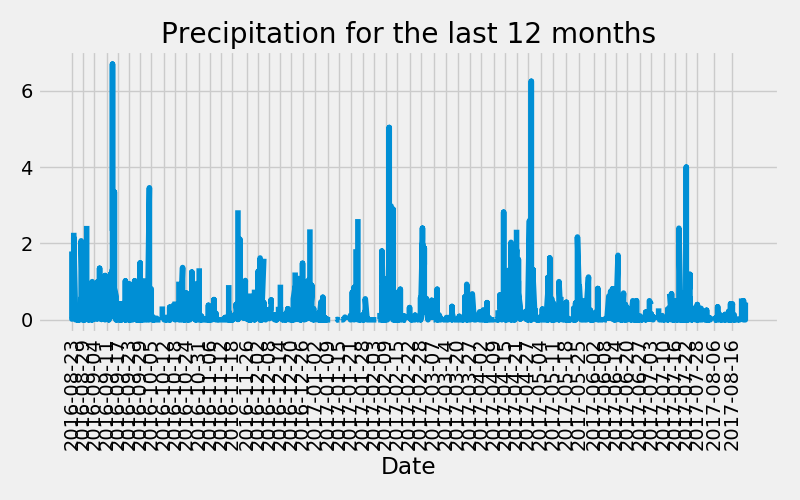

In [10]:
# Use Pandas Plotting with Matplotlib to plot the data
# Rotate the xticks for the dates

fig = plt.figure(figsize = (8,5))
ax = plt.axes()
fig1 = ax.plot(df.index, df['precipitation'])
ax.set_xticks(df.index[::40])
ax.set_xticklabels(df.index[::40], rotation=90)
ax.set_title("Precipitation for the last 12 months")
ax.set_xlabel("Date")
plt.tight_layout()
plt.show()

In [11]:
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [11]:
# How many stations are available in this dataset?
station_count = session.query(func.count(distinct(Measurement.station))).all()
print ("There are" + " " + str(station_count[0][0]) + " " + "unique stations")

There are 9 unique stations


In [12]:
# What are the most active stations? List the stations and the counts in descending order.
active_stations = session.query(func.distinct(Measurement.station), func.count(Measurement.station)).\
                group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [13]:
#Getting temperature summary for all the stations 
sel = [func.distinct(Measurement.station),
       func.min(Measurement.tobs),
       func.avg(Measurement.tobs), 
       func.max(Measurement.tobs)]
summary = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
summary

[('USC00511918', 53.0, 71.61596766043456, 87.0),
 ('USC00513117', 59.0, 72.68918420081211, 85.0),
 ('USC00514830', 58.0, 74.8732970027248, 85.0),
 ('USC00516128', 58.0, 70.91500765696784, 84.0),
 ('USC00517948', 58.0, 74.68440233236151, 87.0),
 ('USC00518838', 58.0, 72.72407045009784, 83.0),
 ('USC00519281', 54.0, 71.66378066378067, 85.0),
 ('USC00519397', 56.0, 74.55323054331865, 87.0),
 ('USC00519523', 56.0, 74.5436493068565, 85.0)]

In [14]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature for MOST ACTIVE STATION

print(f"The station with the highest number of observations: {active_stations[0][0]}")

summary = session.query(*sel).filter(Measurement.station == 'USC00519281').all()
print(f"Summary for station {summary[0][0]}:"
      '\n'f"tmin: {summary[0][1]}" 
      '\n'f"tavg: {summary[0][2]}"
      '\n'f"tmax:{summary[0][3]}")

The station with the highest number of observations: USC00519281
Summary for station USC00519281:
tmin: 54.0
tavg: 71.66378066378067
tmax:85.0


In [15]:
# Choosing the station with the highest number of temperature observations.
highest_temp_count = session.query(Measurement.station, func.count(Measurement.tobs).label("max_temp_obs")).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.tobs).desc()).first()

print(f"Station {highest_temp_count[0]} recorded the highest number of temperature(tobs) observations")

Station USC00519281 recorded the highest number of temperature(tobs) observations


## Temperature (tobs) analysis for station USC00519281.¶

<IPython.core.display.Javascript object>


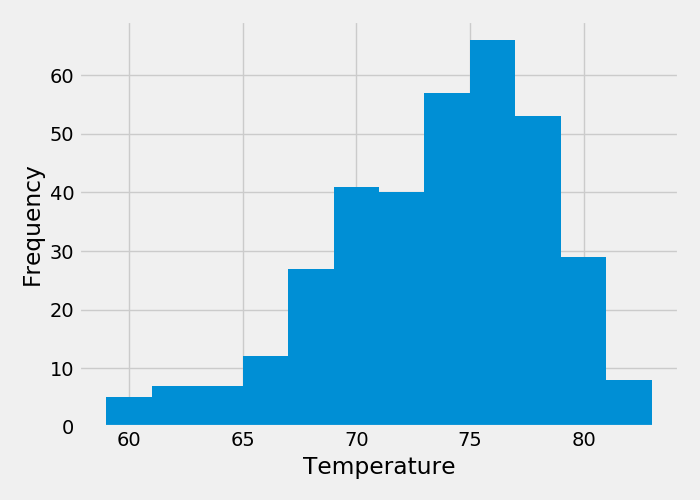

In [16]:
# Quering the last 12 months of temperature observation data for station USC00519281
year_tobs = session.query(Measurement.tobs).filter(Measurement.date>=prev_year).\
        filter(Measurement.station == 'USC00519281').all()
year_tobs = np.array(year_tobs)

#Ploting results as a histogram
fig = plt.figure(figsize = (7,5))
ax = plt.axes()
fig = ax.hist(year_tobs, bins=12)
ax.set_ylabel('Frequency')
ax.set_xlabel('Temperature')
plt.tight_layout()
plt.show()

In [21]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

def calc_temps(start_date, end_date):
    """Returns: TMIN, TAVG, and TMAX"""
    start_date = dt.datetime.strptime(start_date, "%Y-%m-%d").date()
    end_date = dt.datetime.strptime(end_date, "%Y-%m-%d")
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

print(calc_temps('2012-07-01', '2012-07-15'))

[(68.0, 74.73636363636363, 82.0)]


### Weather analysis for the trip

In [22]:
#Out trip dates are between 2018-07-01 and 2018-07-15
#but we calculate the tmin, tavg, and tmax for our trip dates 
#using the previous year's data for those same dates.

summary2017 = calc_temps('2017-07-01', '2017-07-15')
tmin = summary2017[0][0]
tavg = summary2017[0][1]
tmax = summary2017[0][2]
print(f"For the dates between 2018-07-01 and 2018-07-15 we should expect the following weather:"
      '\n'f"tmin: {tmin}" 
      '\n'f"tavg: {tavg}"
      '\n'f"tmax:{tmax}")

For the dates between 2018-07-01 and 2018-07-15 we should expect the following weather:
tmin: 69.0
tavg: 78.25
tmax:87.0


<IPython.core.display.Javascript object>


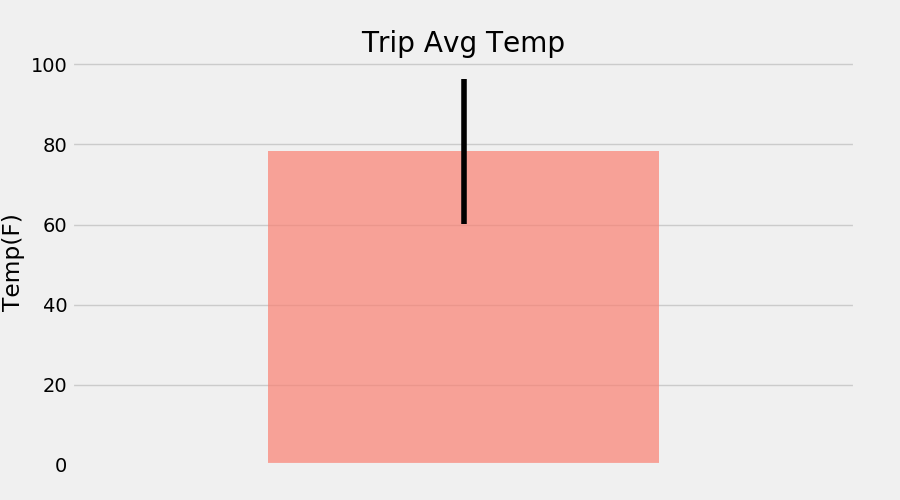

In [26]:
# Plotting the results from our previous query as a bar chart. 
# Using "Trip Avg Temp" as our Title
# Using the average temperature for the y value
# Using the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

width = 0.5 # the width of the bar
fig = plt.figure(figsize = (9,5))
ax = plt.axes()
yerr = tmax - tmin
ax.bar(x=[1], height=tavg, width = width, color = 'salmon', yerr=yerr, alpha=0.7)
ax.set_title('Trip Avg Temp')
ax.set_ylabel('Temp(F)')
ax.set_xticks([])
ax.set_xlim(0.5, 1.5)
plt.show()

In [132]:
#Calculating the rainfall per weather station for our trip dates using the previous year's matching dates.
# Sorting this in descending order by precipitation amount 
# list the station, name, latitude, longitude, and elevation

start_date =  '2017-07-01'
end_date = '2017-07-15'
sel = [Measurement.station, Station.name,
       Station.longitude, Station.latitude, Station.elevation, func.sum(Measurement.prcp).label("total_prcp")]

rainfall_per_station = session.query(*sel).filter(Measurement.station == Station.station).\
                        filter(Measurement.date>=start_date).\
                        filter(Measurement.date<=end_date).\
                        group_by(Measurement.station).\
                        order_by(func.sum(Measurement.prcp).desc()).statement
rain_per_station = pd.read_sql_query(rainfall_per_station, session.bind)
rain_per_station

,station,name,longitude,latitude,elevation,total_prcp
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",-157.80250,21.33310,152.4,2.87
1,USC00519281,"WAIHEE 837.5, HI US",-157.84889,21.45167,32.9,1.64
2,USC00513117,"KANEOHE 838.1, HI US",-157.80150,21.42340,14.6,0.83
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",-157.83740,21.52130,7.0,0.39
4,USC00519397,"WAIKIKI 717.2, HI US",-157.81680,21.27160,3.0,0.21
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",-157.71139,21.33556,19.5,0.13
6,USC00517948,"PEARL CITY, HI US",-157.97510,21.39340,11.9,NaN


## Optional Challenge Assignment: Calculating daily normals for the trip dates

In [27]:
# Creating a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    Args:
        date (str): A date string in the format '%m-%d'   
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """   
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

#Just checking if it works
daily_normals("08-09")

[(69.0, 75.98039215686275, 81.0)]

In [93]:
#Setting the start and end date of the trip
from datetime import datetime
start_date = "2018-07-01"
end_date = "2018-07-15"
start_date = dt.datetime.strptime(start_date, "%Y-%m-%d")

# Using the start and end date, we create a range of dates
date_list = [start_date + dt.timedelta(days=x) for x in range(0, 15)]

# # Stipping off the year and saving a list of %m-%d strings to pass to our function
dates_truncated = [datetime.strftime(d, '%m-%d') for d in date_list]


# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(d) for d in dates_truncated]

# from itertools import chain
# normals = list(chain.from_iterable(normals))

# # Loading the query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
# trip_data = pd.DataFrame(normals, columns=["tmin","tavg","tmax"])
# trip_data['date'] = date_list
# trip_data.set_index('date', inplace=True)
# trip_data.head()

[datetime.datetime(2018, 7, 1, 0, 0),
 datetime.datetime(2018, 7, 2, 0, 0),
 datetime.datetime(2018, 7, 3, 0, 0),
 datetime.datetime(2018, 7, 4, 0, 0),
 datetime.datetime(2018, 7, 5, 0, 0),
 datetime.datetime(2018, 7, 6, 0, 0),
 datetime.datetime(2018, 7, 7, 0, 0),
 datetime.datetime(2018, 7, 8, 0, 0),
 datetime.datetime(2018, 7, 9, 0, 0),
 datetime.datetime(2018, 7, 10, 0, 0),
 datetime.datetime(2018, 7, 11, 0, 0),
 datetime.datetime(2018, 7, 12, 0, 0),
 datetime.datetime(2018, 7, 13, 0, 0),
 datetime.datetime(2018, 7, 14, 0, 0),
 datetime.datetime(2018, 7, 15, 0, 0)]

<IPython.core.display.Javascript object>


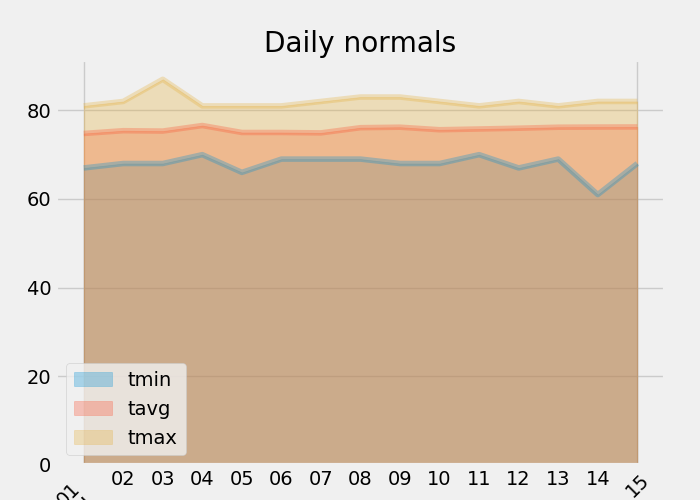

In [117]:
# Plotting the daily normals as an area plot with `stacked=False`
%matplotlib notebook
trip_data.plot.area(alpha=0.3, stacked=False)
plt.xticks(rotation=45)
plt.title("Daily normals")
plt.rcParams["figure.figsize"] = [7, 5]
plt.show()

### I couldn't get the xticks to plot the full date, any suggestions?###